In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')

# Data acquisition
url = "https://huggingface.co/datasets/airt-ml/twitter-human-bots/resolve/main/twitter_human_bots_dataset.csv"
response = requests.get(url)
with open("twitter_human_bots_dataset.csv", "wb") as f:
    f.write(response.content)

# Read the CSV file using pandas
df = pd.read_csv("twitter_human_bots_dataset.csv")

# Data inspection
print("First 5 rows of the dataset:")
print(df.head())

# Handle missing values
df = df.dropna().reset_index(drop=True)

# Encode target variable
le = LabelEncoder()
df['account_type_encoded'] = le.fit_transform(df['account_type'])  # 'bot' -> 0, 'human' -> 1

# Convert boolean columns
boolean_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in boolean_cols:
    df[col] = df[col].astype(int)

# Encode categorical features
df['lang_encoded'] = le.fit_transform(df['lang'])

# Feature selection
df_model = df.drop(columns=[
    'Unnamed: 0', 'created_at', 'id',
    'profile_background_image_url', 'profile_image_url',
    'screen_name', 'location', 'account_type', 'lang'
])

# Define numerical features (excluding the 'description' and 'account_type_encoded' columns)
X_numerical = df_model.drop(columns=['account_type_encoded', 'description'], axis=1)

# Target variable
y = df_model['account_type_encoded']

# Addressing class imbalance in the training data
# Create a DataFrame with the combined features and target
df_combined = pd.DataFrame(X_numerical)

# Ensure the target variable is correctly added
df_combined['account_type_encoded'] = y

# Separate majority and minority classes
df_majority = df_combined[df_combined['account_type_encoded'] == 1]  # Human
df_minority = df_combined[df_combined['account_type_encoded'] == 0]  # Bot

# Oversample the minority class
df_minority_oversampled = resample(df_minority,
                                   replace=True,              # sample with replacement
                                   n_samples=len(df_majority),  # match majority class size
                                   random_state=42)

# Combine majority class with oversampled minority class
df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Separate features and target for balanced dataset
X_balanced = df_balanced.drop('account_type_encoded', axis=1).to_numpy()
y_balanced = df_balanced['account_type_encoded']

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Train-test split with balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

First 5 rows of the dataset:
   Unnamed: 0           created_at  default_profile  default_profile_image  \
0           0  2016-10-15 21:32:11            False                  False   
1           1  2016-11-09 05:01:30            False                  False   
2           2  2017-06-17 05:34:27            False                  False   
3           3  2016-07-21 13:32:25             True                  False   
4           4  2012-01-15 16:32:35            False                  False   

                                         description  favourites_count  \
0  Blame @xaiax, Inspired by @MakingInvisible, us...                 4   
1  Photographing the American West since 1980. I ...               536   
2  Scruffy looking nerf herder and @twitch broadc...              3307   
3  Wife.Godmother.Friend.Feline Fanatic! Assistan...              8433   
4               Loan coach at @mancity & Aspiring DJ                88   

   followers_count  friends_count  geo_enabled           

In [8]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

# Create DataLoader objects for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.4)  # Increased dropout
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.4)  # Increased dropout
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x

# Initialize model, loss function, and optimizer
model = FeedForwardNN(input_size=X_train.shape[1])
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
num_epochs = 50
patience = 5
best_loss = float('inf')
early_stop_count = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
    
    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(test_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}")

# Load the best model
model.load_state_dict(best_model)

# Evaluation on test set
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_pred.extend(outputs.squeeze().numpy())
y_pred = np.array(y_pred)
y_pred_binary = (np.array(y_pred) > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

Epoch 1, Train Loss: 0.5354, Validation Loss: 0.4726
Epoch 2, Train Loss: 0.4939, Validation Loss: 0.4616
Epoch 3, Train Loss: 0.4801, Validation Loss: 0.4494
Epoch 4, Train Loss: 0.4703, Validation Loss: 0.4446
Epoch 5, Train Loss: 0.4662, Validation Loss: 0.4418
Epoch 6, Train Loss: 0.4596, Validation Loss: 0.4396
Epoch 7, Train Loss: 0.4575, Validation Loss: 0.4396
Epoch 8, Train Loss: 0.4549, Validation Loss: 0.4364
Epoch 9, Train Loss: 0.4529, Validation Loss: 0.4364
Epoch 10, Train Loss: 0.4516, Validation Loss: 0.4334
Epoch 11, Train Loss: 0.4505, Validation Loss: 0.4341
Epoch 12, Train Loss: 0.4494, Validation Loss: 0.4338
Epoch 13, Train Loss: 0.4482, Validation Loss: 0.4304
Epoch 14, Train Loss: 0.4492, Validation Loss: 0.4311
Epoch 15, Train Loss: 0.4496, Validation Loss: 0.4313
Epoch 16, Train Loss: 0.4462, Validation Loss: 0.4324
Epoch 17, Train Loss: 0.4455, Validation Loss: 0.4297
Epoch 18, Train Loss: 0.4436, Validation Loss: 0.4275
Epoch 19, Train Loss: 0.4442, Validat

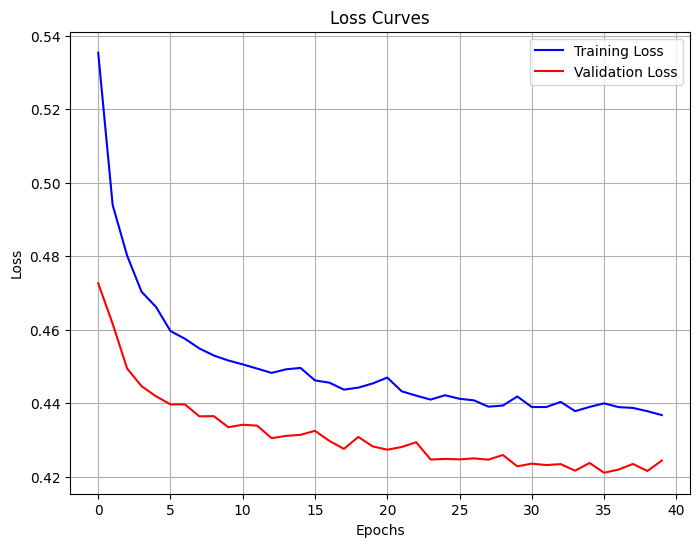

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

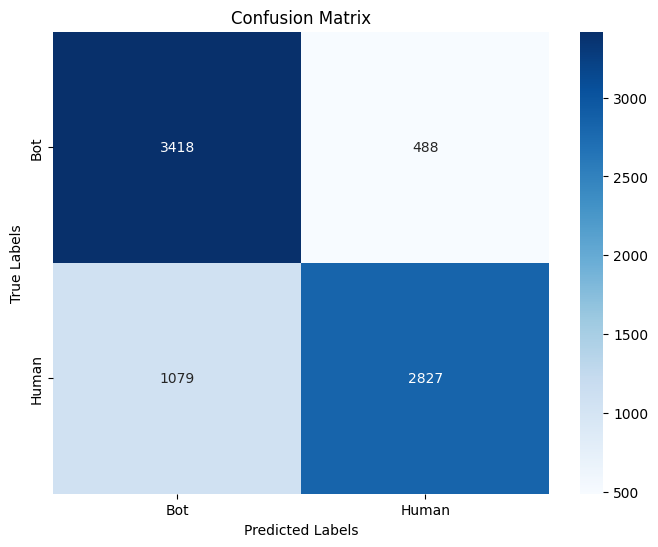

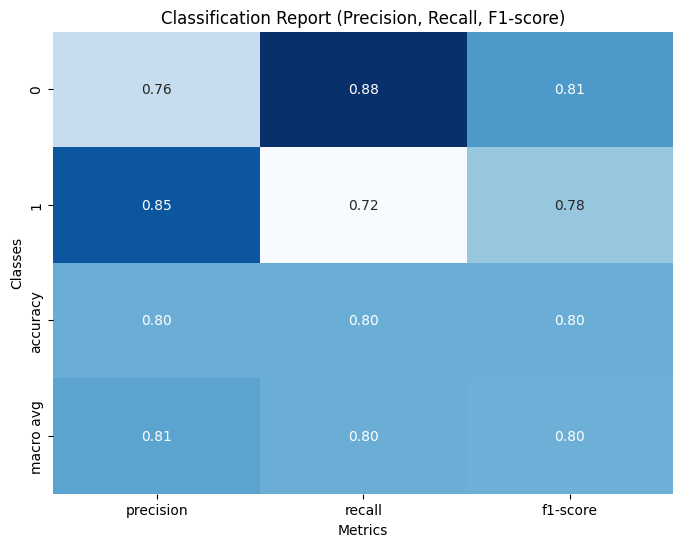

In [10]:
cm = confusion_matrix(y_test, y_pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bot", "Human"], yticklabels=["Bot", "Human"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_binary, output_dict=True)

# Convert classification report to a DataFrame for easy plotting
report_df = pd.DataFrame(report).transpose()

# Plot Classification Report
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Classification Report (Precision, Recall, F1-score)")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()


In [11]:
# Identify misclassified samples
misclassified_indices = np.where(y_test != y_pred)[0]
misclassified_samples = X_test[misclassified_indices]
misclassified_labels = y_test.iloc[misclassified_indices]

# Examine misclassified examples
sample_indices = np.random.choice(misclassified_indices, size=5, replace=False)
for idx in sample_indices:
    actual_label = 'Bot' if y_test.iloc[idx] == 0 else 'Human'
    predicted_label = 'Bot' if y_pred[idx] == 0 else 'Human'
    print(f"Index: {idx}")
    print(f"Actual Label: {actual_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Features: {X_test[idx]}")
    print("-" * 50)

Index: 13
Actual Label: Human
Predicted Label: Human
Features: [-0.70751414 -0.04911578  0.74241187 -0.1454483  -0.10476285  1.09898932
 -0.14988244  2.02662714 -0.11300474 -0.48751869  0.36405513]
--------------------------------------------------
Index: 5839
Actual Label: Bot
Predicted Label: Human
Features: [-0.70751414 -0.04911578 -0.26022657 -0.14933143 -0.03564615  1.09898932
 -0.20448184 -0.49343068 -0.18871607  0.59298658 -0.34663066]
--------------------------------------------------
Index: 4019
Actual Label: Bot
Predicted Label: Human
Features: [-0.70751414 -0.04911578 -0.32367579 -0.15387758 -0.10895174 -0.90992695
 -0.29291778 -0.49343068 -0.25268506  0.18136553  0.83784566]
--------------------------------------------------
Index: 2507
Actual Label: Bot
Predicted Label: Human
Features: [ 1.41339931 -0.04911578 -0.33478996 -0.15391212 -0.11050568 -0.90992695
 -0.29764655 -0.49343068 -0.25650132 -0.0033962   3.20679829]
--------------------------------------------------
Inde

In [18]:
# Identify misclassified examples
misclassified = X_test[y_test != y_pred]
y_misclassified_true = y_test[y_test != y_pred]  # True labels
y_misclassified_pred = y_pred[y_test != y_pred]  # Predicted labels

# Add original features back to the misclassified examples for inspection
misclassified_df = pd.DataFrame(scaler.inverse_transform(misclassified), columns=df_model.drop(columns=['description', 'account_type_encoded']).columns)
misclassified_df['true_label'] = y_misclassified_true.values
misclassified_df['predicted_label'] = y_misclassified_pred

print("First 5 Misclassified Examples:")
print(misclassified_df.head())

First 5 Misclassified Examples:
   default_profile  default_profile_image  favourites_count  followers_count  \
0              0.0                    0.0            5309.0        1258734.0   
1              0.0                    0.0           15186.0          24059.0   
2              0.0                    0.0           15492.0            838.0   
3              0.0                    0.0            2411.0           4900.0   
4              1.0                    0.0            1097.0            115.0   

   friends_count  geo_enabled  statuses_count  verified  \
0          705.0          1.0          6526.0       1.0   
1            4.0          0.0         15870.0       0.0   
2         1376.0          1.0         15458.0       0.0   
3        12713.0          0.0          6325.0       0.0   
4          196.0          1.0          2576.0       0.0   

   average_tweets_per_day  account_age_days  lang_encoded  true_label  \
0                   2.253            2897.0           9.0  

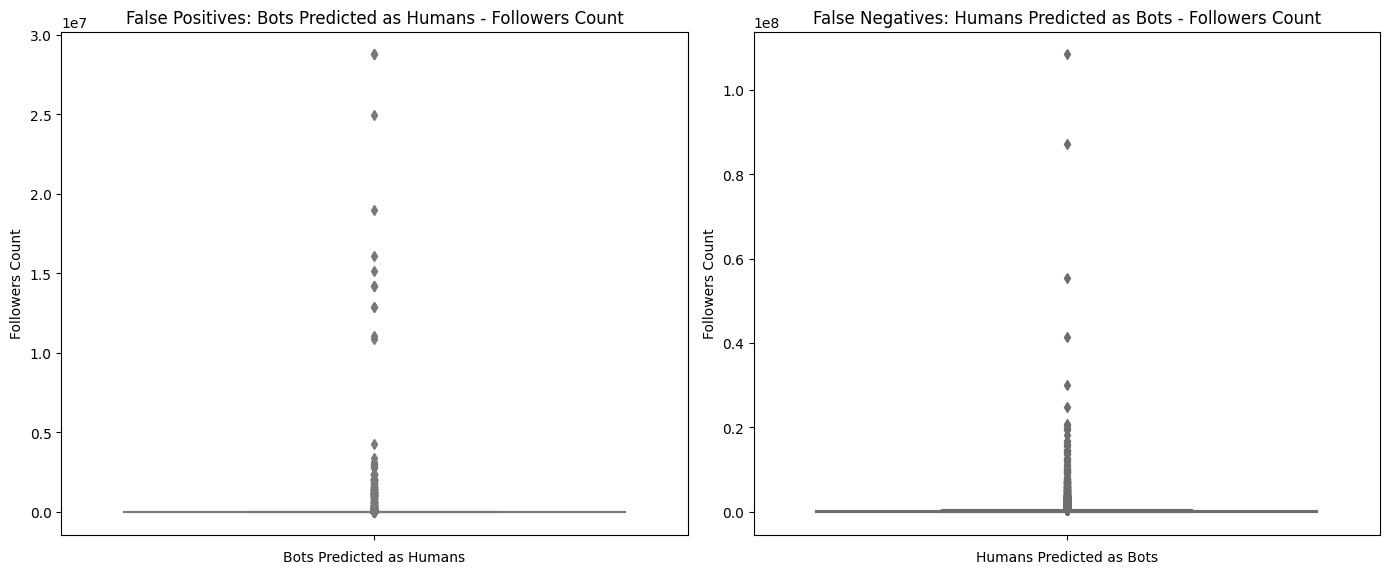

In [19]:
# Filter misclassifications by type
false_positives = misclassified_df[misclassified_df['true_label'] == 0]  # Bots misclassified as Humans
false_negatives = misclassified_df[misclassified_df['true_label'] == 1]  # Humans misclassified as Bots

# Plot followers and friends counts for each error type
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=false_positives, y='followers_count', color='lightblue')
plt.title('False Positives: Bots Predicted as Humans - Followers Count')
plt.xlabel('Bots Predicted as Humans')
plt.ylabel('Followers Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=false_negatives, y='followers_count', color='salmon')
plt.title('False Negatives: Humans Predicted as Bots - Followers Count')
plt.xlabel('Humans Predicted as Bots')
plt.ylabel('Followers Count')

plt.tight_layout()
plt.show()

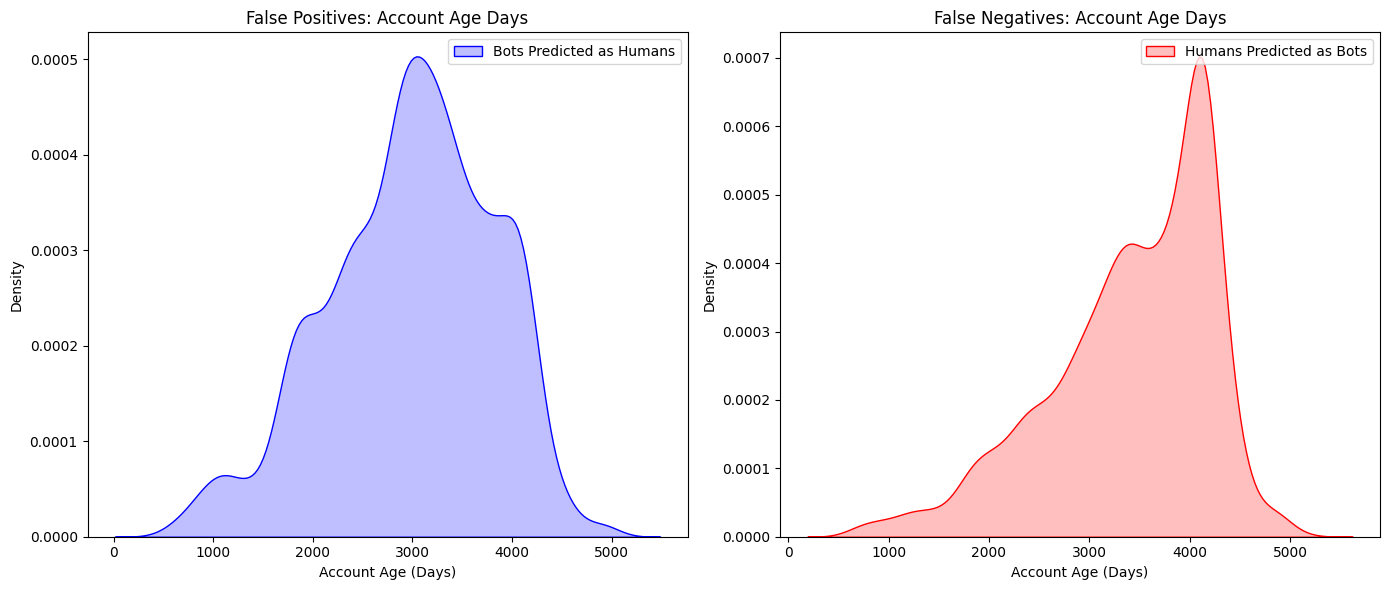

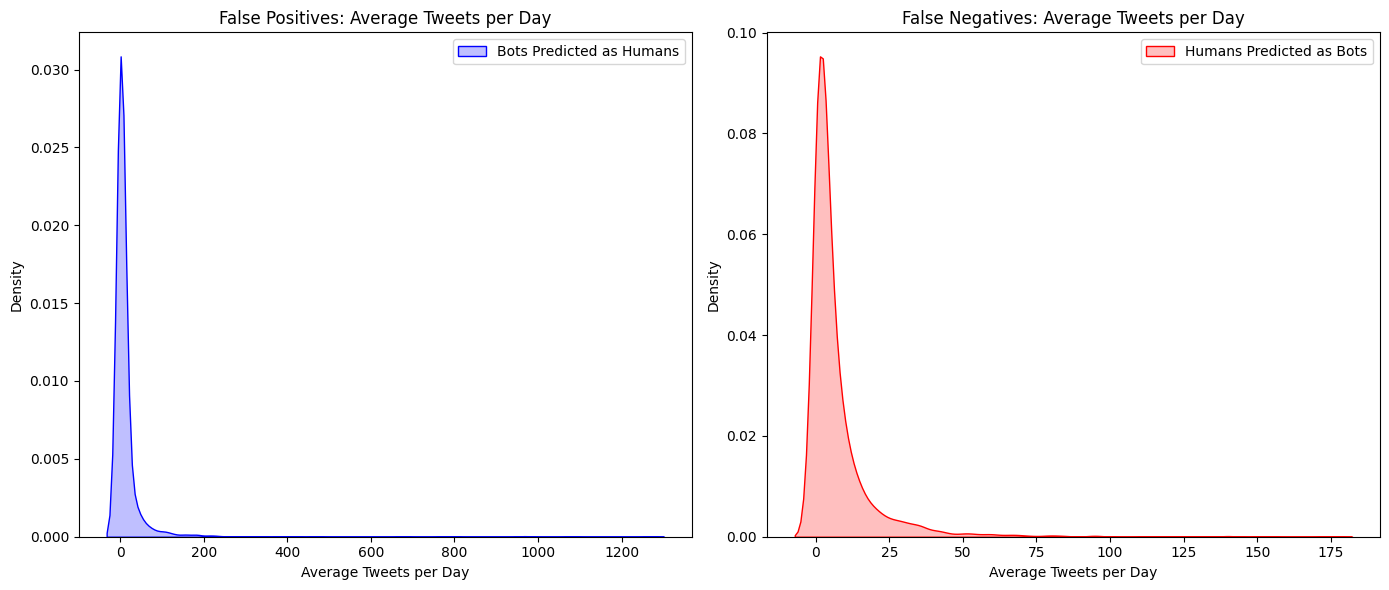

In [20]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(
    data=false_positives, x='account_age_days', fill=True, color='blue', label='Bots Predicted as Humans'
)
plt.title('False Positives: Account Age Days')
plt.xlabel('Account Age (Days)')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(
    data=false_negatives, x='account_age_days', fill=True, color='red', label='Humans Predicted as Bots'
)
plt.title('False Negatives: Account Age Days')
plt.xlabel('Account Age (Days)')
plt.legend()

plt.tight_layout()
plt.show()

# Density plots for average tweets per day
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(
    data=false_positives, x='average_tweets_per_day', fill=True, color='blue', label='Bots Predicted as Humans'
)
plt.title('False Positives: Average Tweets per Day')
plt.xlabel('Average Tweets per Day')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(
    data=false_negatives, x='average_tweets_per_day', fill=True, color='red', label='Humans Predicted as Bots'
)
plt.title('False Negatives: Average Tweets per Day')
plt.xlabel('Average Tweets per Day')
plt.legend()

plt.tight_layout()
plt.show()

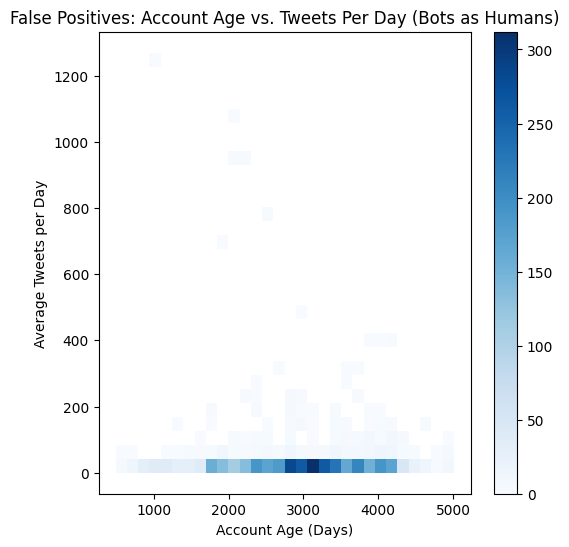

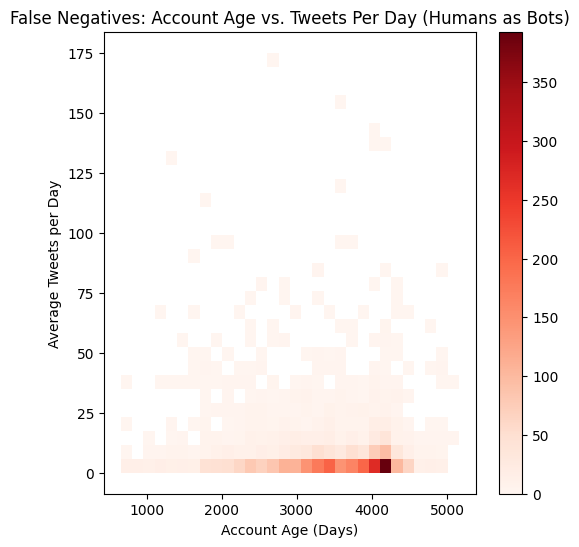

In [21]:
# False positives heatmap
plt.figure(figsize=(6, 6))
sns.histplot(
    data=false_positives, x='account_age_days', y='average_tweets_per_day',
    bins=30, cmap="Blues", cbar=True
)
plt.title('False Positives: Account Age vs. Tweets Per Day (Bots as Humans)')
plt.xlabel('Account Age (Days)')
plt.ylabel('Average Tweets per Day')
plt.show()

# False negatives heatmap
plt.figure(figsize=(6, 6))
sns.histplot(
    data=false_negatives, x='account_age_days', y='average_tweets_per_day',
    bins=30, cmap="Reds", cbar=True
)
plt.title('False Negatives: Account Age vs. Tweets Per Day (Humans as Bots)')
plt.xlabel('Account Age (Days)')
plt.ylabel('Average Tweets per Day')
plt.show()

In [27]:
# Separate correctly classified samples
correctly_classified = X_test[y_test == y_pred_binary]
y_correct_true = y_test[y_test == y_pred_binary]

# Convert scaled data back to original values for better interpretability
correctly_classified_df = pd.DataFrame(scaler.inverse_transform(correctly_classified), columns=df_model.drop(columns=['description', 'account_type_encoded']).columns)
correctly_classified_df['true_label'] = y_correct_true.values
correctly_classified_df['classification_status'] = 'Correct'

# Update misclassified dataframe for labeling
misclassified_df['classification_status'] = 'Misclassified'

# Combine for easier comparison in plots
comparison_df = pd.concat([correctly_classified_df, misclassified_df])

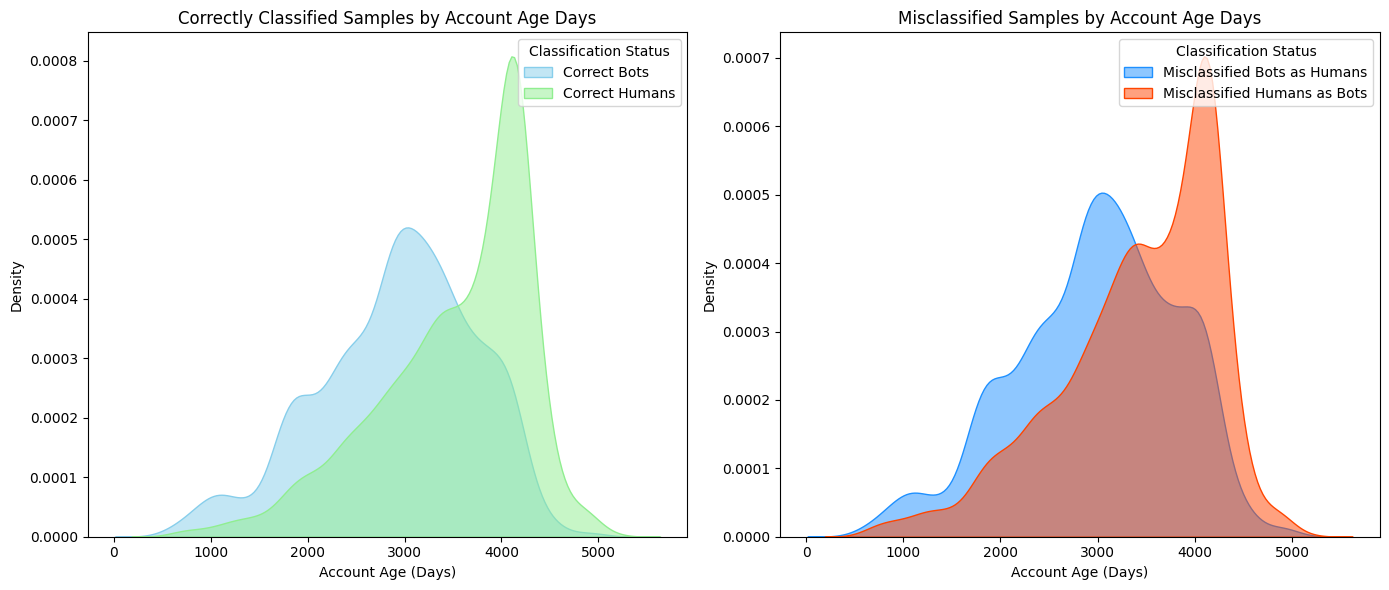

In [28]:
# Density plot for account_age_days with enriched labeling and improved clarity
plt.figure(figsize=(14, 6))

# Plot for Correctly Classified Samples
plt.subplot(1, 2, 1)
sns.kdeplot(
    data=comparison_df[(comparison_df['classification_status'] == 'Correct') & (comparison_df['true_label'] == 0)],
    x='account_age_days', fill=True, color='skyblue', alpha=0.5, label='Correct Bots'
)
sns.kdeplot(
    data=comparison_df[(comparison_df['classification_status'] == 'Correct') & (comparison_df['true_label'] == 1)],
    x='account_age_days', fill=True, color='lightgreen', alpha=0.5, label='Correct Humans'
)
plt.title('Correctly Classified Samples by Account Age Days')
plt.xlabel('Account Age (Days)')
plt.ylabel('Density')
plt.legend(title="Classification Status", loc='upper right')

# Plot for Misclassified Samples
plt.subplot(1, 2, 2)
sns.kdeplot(
    data=comparison_df[(comparison_df['classification_status'] == 'Misclassified') & (comparison_df['true_label'] == 0)],
    x='account_age_days', fill=True, color='dodgerblue', alpha=0.5, label='Misclassified Bots as Humans'
)
sns.kdeplot(
    data=comparison_df[(comparison_df['classification_status'] == 'Misclassified') & (comparison_df['true_label'] == 1)],
    x='account_age_days', fill=True, color='orangered', alpha=0.5, label='Misclassified Humans as Bots'
)
plt.title('Misclassified Samples by Account Age Days')
plt.xlabel('Account Age (Days)')
plt.ylabel('Density')
plt.legend(title="Classification Status", loc='upper right')

plt.tight_layout()
plt.show()